In [98]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from tabulate import tabulate

# Dataset class
class CUB200Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = pd.read_csv(os.path.join(root_dir, 'images.txt'), sep=' ', names=['id', 'filepath'])
        self.labels = pd.read_csv(os.path.join(root_dir, 'image_class_labels.txt'), sep=' ', names=['id', 'label'])
        self.bboxes = pd.read_csv(os.path.join(root_dir, 'bounding_boxes.txt'), sep=' ', names=['id', 'x', 'y', 'width', 'height'])
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, 'images', self.images.iloc[idx]['filepath'])
        image = Image.open(img_path).convert('RGB')
        bbox = self.bboxes.iloc[idx][['x', 'y', 'width', 'height']].values
        bbox = torch.tensor(bbox, dtype=torch.float32)
        label = self.labels.iloc[idx]['label']
        if self.transform:
            image = self.transform(image)
        return image, label, bbox

# Image transformation
def cub_transform(image_size=448):
    train_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])
    return train_transform

train_transform = cub_transform()
train_dataset = CUB200Dataset(root_dir='CUB_200_2011/CUB_200_2011', transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
model.load_state_dict(torch.load('cub_pytorch_resnet50.pth', map_location=device))
model = model.to(device)
model.eval()

# Adjust threshold for CAM extraction
def extract_high_intensity_region(heatmap, threshold=0.7):  # Increased threshold for more focus
    _, thresholded = cv2.threshold(heatmap, threshold * heatmap.max(), 255, cv2.THRESH_BINARY)
    thresholded = np.uint8(thresholded)
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        return cv2.boundingRect(largest_contour)
    return 0, 0, 0, 0  # If no contours are found

# GradCAM class
import torch.nn.functional as F
class GradCAM:
    def __init__(self, model, layers):
        self.model = model
        self.layers = layers
        self.gradients = {}
        self.feature_maps = {}
        self.model.eval()
        self.register_hooks()

    def save_gradient(self, layer_name):
        def hook(module, grad_input, grad_output):
            self.gradients[layer_name] = grad_output[0]
        return hook

    def forward_hook(self, layer_name):
        def hook(module, input, output):
            self.feature_maps[layer_name] = output
        return hook

    def register_hooks(self):
        for layer_name in self.layers:
            layer = dict([*self.model.named_modules()])[layer_name]
            layer.register_forward_hook(self.forward_hook(layer_name))
            layer.register_full_backward_hook(self.save_gradient(layer_name))

    def generate_gradcam(self, input_image, target_class):
        model_output = self.model(input_image)
        if target_class is None:
            target_class = model_output.argmax(dim=1)
        
        class_loss = model_output[:, target_class]
        self.model.zero_grad()
        class_loss.backward()

        cams = []
        for layer_name in self.layers:
            gradients = self.gradients[layer_name]
            feature_maps = self.feature_maps[layer_name]
            pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
            for i in range(pooled_gradients.size(0)):
                feature_maps[0][i, :, :] *= pooled_gradients[i]
            cam = torch.sum(feature_maps[0], dim=0)
            cam = torch.relu(cam)
            cam = cam - cam.min()
            cam = cam / cam.max()
            cam = cv2.resize(cam.detach().cpu().numpy(), (input_image.shape[2], input_image.shape[3]))  # Resize to input image size
            cams.append(cam)
        
        # Combine CAMs from multiple layers
        combined_cam = np.mean(cams, axis=0)
        return combined_cam

# Apply colormap on image
def apply_colormap_on_image(org_img, cam, alpha=0.8):
    # Ensure original image is in the correct format
    if org_img.dtype != np.uint8:
        org_img = np.uint8(255 * org_img)

    # Enhance the CAM contrast
    cam = enhance_cam_contrast(cam, 'power', 2)
    cam_resized = cv2.resize(cam, (org_img.shape[1], org_img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)

    # Check if original image is single channel, convert it to 3 channels
    if len(org_img.shape) == 2 or org_img.shape[2] == 1:
        org_img = cv2.cvtColor(org_img, cv2.COLOR_GRAY2RGB)

    # Blend the heatmap with the original image
    final_image = cv2.addWeighted(org_img, 1 - alpha, heatmap, alpha, 0)
    return final_image

def enhance_cam_contrast(cam, method='power', factor=2):
    if method == 'log':
        cam = np.log1p(cam)
    elif method == 'power':
        cam = np.power(cam, factor)
    cam = cam - cam.min()  # Normalize
    cam = cam / cam.max()
    return cam

def apply_clahe(heatmap):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    heatmap_gray = cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY)
    return clahe.apply(heatmap_gray)

# Calculate IoU
def calculate_iou(boxA, boxB):
    # Determine the coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    
    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    
    # Compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] + 1) * (boxA[3] + 1)
    boxBArea = (boxB[2] + 1) * (boxB[3] + 1)
    
    # Compute the intersection over union by taking the intersection area
    # and dividing it by the sum of prediction + ground-truth areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    return iou

# Visualize GradCAM
def visualize_gradcam(image, gt_bbox, cam_bbox, heatmap, iou):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.gca().add_patch(plt.Rectangle((gt_bbox[0], gt_bbox[1]), gt_bbox[2], gt_bbox[3], fill=False, edgecolor='green', linewidth=2))
    plt.gca().add_patch(plt.Rectangle((cam_bbox[0], cam_bbox[1]), cam_bbox[2], cam_bbox[3], fill=False, edgecolor='red', linewidth=2))
    print("Result for GradCAM")
    plt.title(f'Ground Truth and CAM Bounding Box\nIoU: {iou:.2f}')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.imshow(heatmap, cmap='jet', alpha=0.8)  # Increased alpha for overlay
    plt.title('Heatmap')
    plt.axis('off')
    plt.show()

# Visualize CAM for different layers
def visualize_layer_gradcam(model, layers, image, label):
    fig, axs = plt.subplots(1, len(layers), figsize=(15, 5))
    for i, layer in enumerate(layers):
        grad_cam = GradCAM(model, [layer])
        cam = grad_cam.generate_gradcam(image.unsqueeze(0), label)
        cam_resized = cv2.resize(cam, (image.shape[2], image.shape[1]))
        heatmap = plt.cm.jet(cam_resized)[:, :, :3]
        axs[i].imshow(image.permute(1, 2, 0).numpy())
        axs[i].imshow(heatmap, alpha=0.5)
        axs[i].set_title(f'Layer: {layer}')
        axs[i].axis('off')
    plt.show()

print("Done")

Done


In [99]:
class GradCAMPlusPlus(GradCAM):
    def generate_gradcamplusplus(self, input_image, target_class):
        model_output = self.model(input_image)
        if target_class is None:
            target_class = model_output.argmax(dim=1)
        
        class_loss = model_output[:, target_class]
        self.model.zero_grad()
        class_loss.backward()

        cams = []
        for layer_name in self.layers:
            gradients = self.gradients[layer_name]
            feature_maps = self.feature_maps[layer_name]
            alpha_num = gradients.pow(2)
            alpha_denom = 2 * gradients.pow(2) + torch.sum(feature_maps * gradients.pow(3), dim=[2, 3], keepdim=True)
            alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.ones_like(alpha_denom))
            alphas = alpha_num / alpha_denom
            weights = torch.relu(gradients)
            weights = torch.sum(weights * alphas, dim=[2, 3], keepdim=True)

            cam = torch.sum(weights * feature_maps, dim=1).squeeze(0)
            cam = torch.relu(cam)
            cam = cam - cam.min()
            cam = cam / cam.max()
            cam = cv2.resize(cam.detach().cpu().numpy(), (input_image.shape[2], input_image.shape[3]))  # Resize to input image size
            cams.append(cam)
        
        combined_cam = np.mean(cams, axis=0)
        return combined_cam
def visualize_gradcamplusplus(image, gt_bbox, cam_bbox, heatmap, iou):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.gca().add_patch(plt.Rectangle((gt_bbox[0], gt_bbox[1]), gt_bbox[2], gt_bbox[3], fill=False, edgecolor='green', linewidth=2))
    plt.gca().add_patch(plt.Rectangle((cam_bbox[0], cam_bbox[1]), cam_bbox[2], cam_bbox[3], fill=False, edgecolor='red', linewidth=2))
    print("Result for GradCAM++")
    plt.title(f'Ground Truth and CAM Bounding Box\nIoU: {iou:.2f}')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.imshow(heatmap, cmap='jet', alpha=0.8)  # Increased alpha for overlay
    plt.title('Heatmap')
    plt.axis('off')
    plt.show()

print("DONE")

DONE


In [100]:
import torch.nn.functional as F
class ScoreCAM:
    def __init__(self, model, layers):
        self.model = model
        self.layers = layers
        self.feature_maps = {}
        self.model.eval()
        self.register_hooks()

    def forward_hook(self, layer_name):
        def hook(module, input, output):
            self.feature_maps[layer_name] = output
        return hook

    def register_hooks(self):
        for layer_name in self.layers:
            layer = dict([*self.model.named_modules()])[layer_name]
            layer.register_forward_hook(self.forward_hook(layer_name))

    def generate_cam(self, input_image, target_class):
        model_output = self.model(input_image)
        if target_class is None:
            target_class = model_output.argmax(dim=1)

        # Get feature maps
        feature_maps = [self.feature_maps[layer] for layer in self.layers]

        # Get weight for each feature map
        weights = []
        for layer_name, feature_map in zip(self.layers, feature_maps):
            saliency_map = torch.mean(feature_map, dim=1, keepdim=True)
            saliency_map = F.interpolate(saliency_map, size=input_image.shape[2:], mode='bilinear', align_corners=False)
            norm_saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min() + 1e-5)
            output = self.model(input_image * norm_saliency_map)
            weights.append(output[0][target_class].item())

            # Visualize the saliency map
            plt.imshow(norm_saliency_map.detach().cpu().squeeze(), cmap='jet')
            plt.title(f'Saliency Map for Layer {layer_name}')
            plt.show()

        print(f"Weights: {weights}")

        # Validate if weights make sense
        if not any(weights):
            print("All weights are zero, check weight calculation.")
            return None

        # Calculate weighted sum of feature maps
        cam = torch.zeros((input_image.shape[2], input_image.shape[3]), dtype=torch.float32).to(input_image.device)
        for i, feature_map in enumerate(feature_maps):
            resized_feature_map = F.interpolate(feature_map, size=input_image.shape[2:], mode='bilinear', align_corners=False)
            cam += weights[i] * resized_feature_map[0, 0]

        print(f"CAM before ReLU: {cam}")

        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / cam.max()

        print(f"CAM after normalization: {cam}")

        return cam.detach().cpu().numpy()
# Visualize ScoreCAM
def visualize_scorecam(image, gt_bbox, cam_bbox, heatmap, iou):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.gca().add_patch(plt.Rectangle((gt_bbox[0], gt_bbox[1]), gt_bbox[2], gt_bbox[3], fill=False, edgecolor='green', linewidth=2))
    plt.gca().add_patch(plt.Rectangle((cam_bbox[0], cam_bbox[1]), cam_bbox[2], cam_bbox[3], fill=False, edgecolor='red', linewidth=2))
    print("Result for ScoreCAM")
    plt.title(f'Ground Truth and CAM Bounding Box\nIoU: {iou:.2f}')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.imshow(heatmap, cmap='jet', alpha=0.8)  # Increased alpha for overlay
    plt.title('Heatmap')
    plt.axis('off')
    plt.show()


In [101]:
import torch.nn.functional as F

class LiftCAM:
    def __init__(self, model, layers):
        self.model = model
        self.layers = layers
        self.feature_maps = {}
        self.model.eval()
        self.register_hooks()

    def forward_hook(self, layer_name):
        def hook(module, input, output):
            self.feature_maps[layer_name] = output
        return hook

    def register_hooks(self):
        for layer_name in self.layers:
            layer = dict([*self.model.named_modules()])[layer_name]
            layer.register_forward_hook(self.forward_hook(layer_name))

    def generate_cam(self, input_image, target_class):
        model_output = self.model(input_image)
        if target_class is None:
            target_class = model_output.argmax(dim=1)

        # Get feature maps
        feature_maps = [self.feature_maps[layer] for layer in self.layers]

        # Calculate CAM using feature maps without gradients
        cams = []
        for feature_map in feature_maps:
            cam = torch.mean(feature_map, dim=1, keepdim=True)  # Global average pooling
            cam = cam - cam.min()
            cam = cam / cam.max()
            cam = F.interpolate(cam, size=(input_image.shape[2], input_image.shape[3]), mode='bilinear', align_corners=False)
            cams.append(cam.squeeze(0).squeeze(0))

        # Combine CAMs from multiple layers
        combined_cam = torch.mean(torch.stack(cams), dim=0)
        return combined_cam.detach().cpu().numpy()

# Visualize LIFT-CAM
def visualize_liftcam(image, gt_bbox, cam_bbox, heatmap, iou):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.gca().add_patch(plt.Rectangle((gt_bbox[0], gt_bbox[1]), gt_bbox[2], gt_bbox[3], fill=False, edgecolor='green', linewidth=2))
    plt.gca().add_patch(plt.Rectangle((cam_bbox[0], cam_bbox[1]), cam_bbox[2], cam_bbox[3], fill=False, edgecolor='red', linewidth=2))
    print("Result for LIFT-CAM")
    plt.title(f'Ground Truth and CAM Bounding Box\nIoU: {iou:.2f}')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.imshow(heatmap, cmap='jet', alpha=0.8)  # Increased alpha for overlay
    plt.title('Heatmap')
    plt.axis('off')
    plt.show()

Result for GradCAM


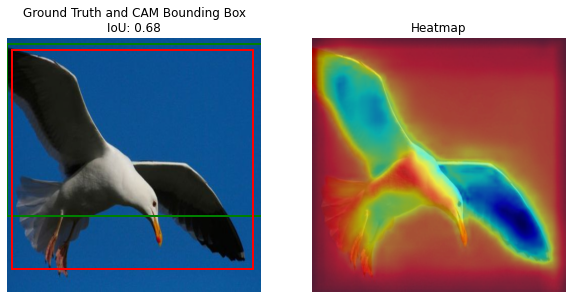

Result for GradCAM++


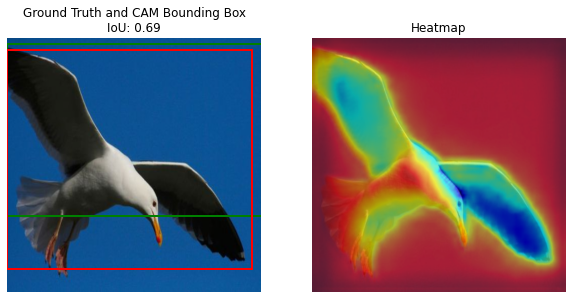

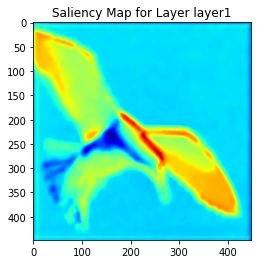

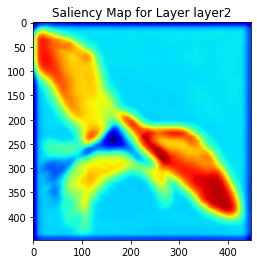

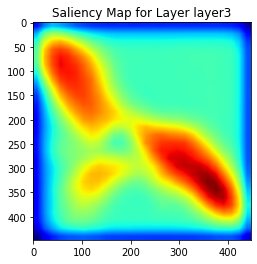

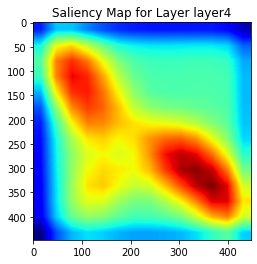

Weights: [6.3097405433654785, 7.179976463317871, 7.8340020179748535, 8.095025062561035]
CAM before ReLU: tensor([[1.0293e+00, 1.0293e+00, 9.6190e-01,  ..., 4.0643e-02, 0.0000e+00,
         0.0000e+00],
        [1.0293e+00, 1.0293e+00, 9.6190e-01,  ..., 4.0643e-02, 0.0000e+00,
         0.0000e+00],
        [1.3017e+00, 1.3017e+00, 1.2372e+00,  ..., 1.5989e-01, 8.5191e-02,
         8.5191e-02],
        ...,
        [3.8436e+00, 3.8436e+00, 3.7421e+00,  ..., 2.1148e+02, 2.1113e+02,
         2.1113e+02],
        [3.9642e+00, 3.9642e+00, 3.8644e+00,  ..., 2.1150e+02, 2.1112e+02,
         2.1112e+02],
        [3.9642e+00, 3.9642e+00, 3.8644e+00,  ..., 2.1150e+02, 2.1112e+02,
         2.1112e+02]], grad_fn=<AddBackward0>)
CAM after normalization: tensor([[3.7946e-03, 3.7946e-03, 3.5460e-03,  ..., 1.4983e-04, 0.0000e+00,
         0.0000e+00],
        [3.7946e-03, 3.7946e-03, 3.5460e-03,  ..., 1.4983e-04, 0.0000e+00,
         0.0000e+00],
        [4.7988e-03, 4.7988e-03, 4.5607e-03,  ..., 5.894

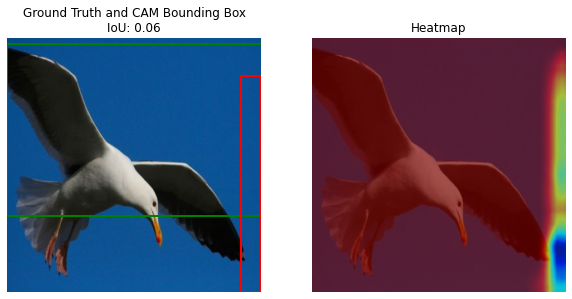

Result for LIFT-CAM


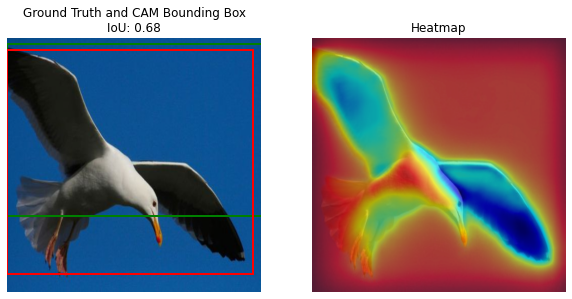

+---+-----------+----------------------+
|   |  Method   |         IoU          |
+---+-----------+----------------------+
| 0 |  GradCAM  |   0.68337398307443   |
| 1 | GradCAM++ |  0.6921445814575585  |
| 2 | ScoreCAM  | 0.061744261942091205 |
| 3 | LIFT-CAM  |  0.6801755085759872  |
+---+-----------+----------------------+


In [107]:

# Function to display IoU results in a table
def display_iou_results(iou_gradcam, iou_gradcam_pp, iou_scorecam, iou_liftcam):
    data = {
        'Method': ['GradCAM', 'GradCAM++', 'ScoreCAM', 'LIFT-CAM'],
        'IoU': [iou_gradcam, iou_gradcam_pp, iou_scorecam, iou_liftcam]
    }
    iou_results_df = pd.DataFrame(data)
    table = tabulate(iou_results_df, headers='keys', tablefmt='pretty')
    print(table)
    
layer_names = ['layer1', 'layer2', 'layer3', 'layer4']
count = 0
# Main loop for GradCAM, GradCAM++, and ScoreCAM
for images, labels, bboxes in train_loader:
    images, labels, bboxes = images.to(device), labels.to(device), bboxes.to(device)
    outputs = model(images)
    target_class = labels[0].item()  # For demonstration
    
    # GradCAM
    grad_cam = GradCAM(model, layer_names)
    cam = grad_cam.generate_gradcam(images, target_class)
    image_np = images.cpu().squeeze(0).permute(1, 2, 0).numpy()
    image_np = (image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)
    heatmap = apply_colormap_on_image(image_np, cam)
    cam_bbox = extract_high_intensity_region(cam, threshold=0.5)
    gt_bbox = bboxes[0].cpu().numpy()
    iou_gradcam = calculate_iou(gt_bbox, cam_bbox)
    visualize_gradcam(image_np, gt_bbox, cam_bbox, heatmap, iou_gradcam)
    
    # GradCAM++
    grad_cam_pp = GradCAMPlusPlus(model, layer_names)
    cam_pp = grad_cam_pp.generate_gradcamplusplus(images, target_class)
    heatmap_pp = apply_colormap_on_image(image_np, cam_pp)
    cam_bbox_pp = extract_high_intensity_region(cam_pp, threshold=0.5)
    iou_gradcam_pp = calculate_iou(gt_bbox, cam_bbox_pp)
    visualize_gradcamplusplus(image_np, gt_bbox, cam_bbox_pp, heatmap_pp, iou_gradcam_pp)
    
    score_cam = ScoreCAM(model, layer_names)
    cam_sc = score_cam.generate_cam(images, target_class)
    if cam_sc is not None:  # Ensure CAM is valid
        heatmap_sc = apply_colormap_on_image(image_np, cam_sc)
        cam_bbox_sc = extract_high_intensity_region(cam_sc, threshold=0.5)
        iou_scorecam = calculate_iou(gt_bbox, cam_bbox_sc)
        visualize_scorecam(image_np, gt_bbox, cam_bbox_sc, heatmap_sc, iou_scorecam)
    else:
        iou_scorecam = 0.0  # Handle invalid CAM case
    
    # LIFT-CAM
    lift_cam = LiftCAM(model, layer_names)
    cam_lift = lift_cam.generate_cam(images, target_class)
    heatmap_lift = apply_colormap_on_image(image_np, cam_lift)
    cam_bbox_lift = extract_high_intensity_region(cam_lift, threshold=0.5)
    iou_liftcam = calculate_iou(gt_bbox, cam_bbox_lift)
    visualize_liftcam(image_np, gt_bbox, cam_bbox_lift, heatmap_lift, iou_liftcam)
    
    # Display IoU results
    display_iou_results(iou_gradcam, iou_gradcam_pp, iou_scorecam, iou_liftcam)
    
    break
    # count = count + 1
    # if (count==3):
    #     break
    # else:
    #     continue